# Management strategy evaluation

Rather than experimenting with a handful of strategies, we can seek to optimize a strategy.  Here we introduce a technique for multi-dimensional optimization of nonlinear, stochastic systems based on Gaussian processes.  While we have so far considered agents whose behavior is set by a single parameter, this approach is also suitable for more complex policies involving multiple parameters.  

In [1]:
from fish import fish
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process
from utils import simulate
from utils import plot_sim


In [2]:
env = fish()

In [3]:
# A simple agent
class some_agent:
    def __init__(self, effort):
        self.effort = effort

    def predict(self, obs, **kwargs):
        return self.effort



To improve convergence, we will define a optimization function that computes the average reward over 100 simulations.  Becuase the optimizer seeks to 'minimize' the value, we will also need to take the negative of the average episode reward

In [4]:


def g(x):
    agent = some_agent(x)
    def my_function(i):
        np.random.seed(i)
        df, mu = simulate(agent, env, timeseries=False)
        return mu
    # do 100 simulations at each value to reduce noise    
    results = [my_function(i) for i in range(100)]
    return -np.mean(results)



In [5]:
%%time
# look for actions between [0,1] 
res = gp_minimize(g, [(0, .2)], n_calls = 20, verbose=True, n_jobs=-1)
res.fun, res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.5158
Function value obtained: -20.6246
Current minimum: -20.6246
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.2886
Function value obtained: -20.1862
Current minimum: -20.6246
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.3313
Function value obtained: -20.1911
Current minimum: -20.6246
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.2207
Function value obtained: -20.1959
Current minimum: -20.6246
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.1060
Function value obtained: -20.2008
Current minimum: -20.6246
Iteration No: 6

(-39.56058762771792, [0.13802943302816162])

37.714195497861446


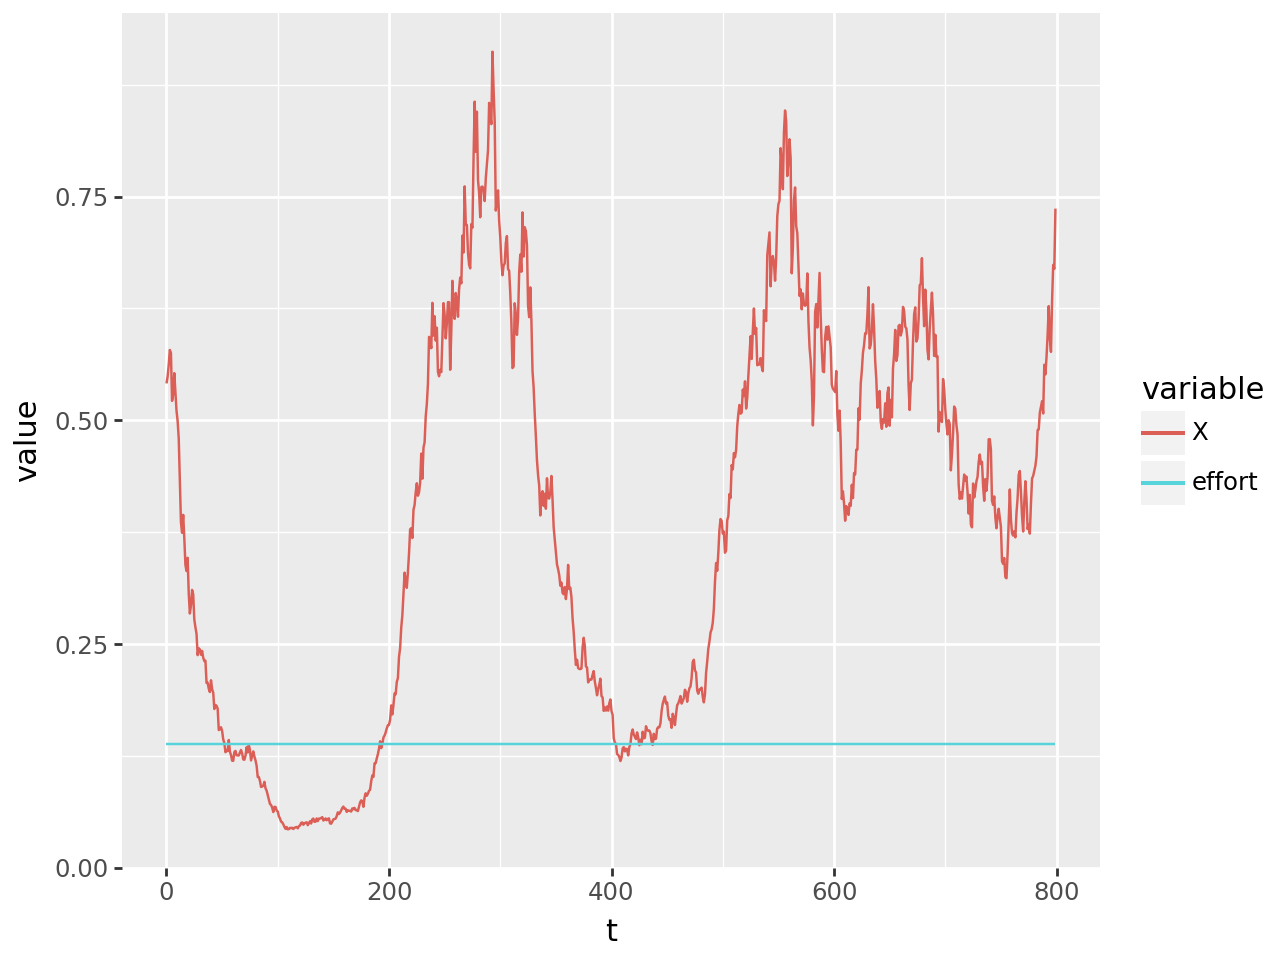

In [6]:

agent = some_agent(*res.x)
df, mu = simulate(agent, env)
print(mu)
plot_sim(df)

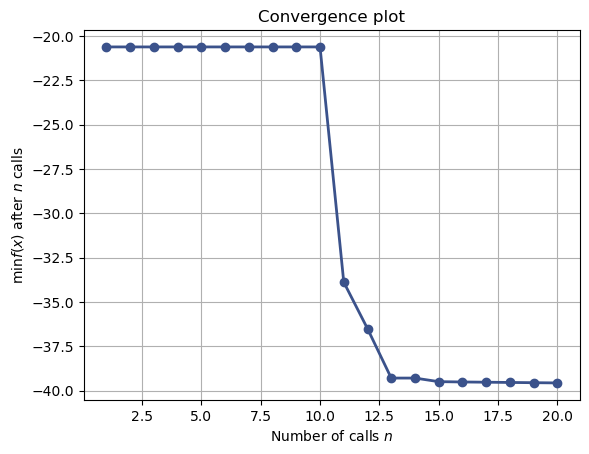

In [7]:

ax2 = plot_convergence(res)

plt.show()

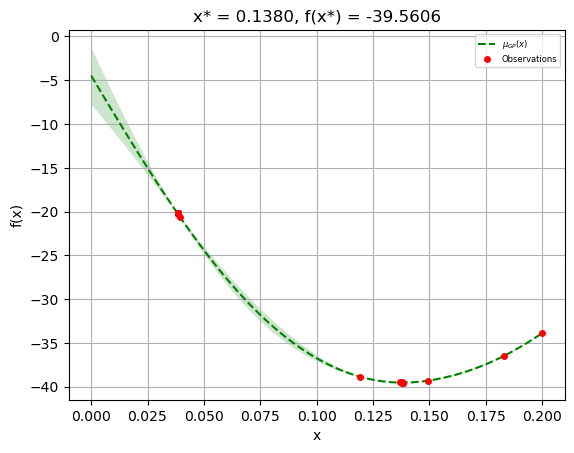

In [8]:

ax2 = plot_gaussian_process(res)

plt.show()

This approach still requires that we define the agent's general behavior.  In principle, an agent could take a different response based on any possible observation -- that is, any map, `action_t = agent(observation_t)`.  Neural networks have consistently proven to be highly flexible function approximators given ample data.  In our next section we will seek to use neural networks as general purpose maps from observation space to action space.  

In [9]:
from sb3_contrib import TQC, ARS
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(fish, 12)


In [10]:
model = ARS("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs")
model.learn(total_timesteps=800_000, tb_log_name="ars-fish", progress_bar=True)
model.save("ars_fish")

Output()

/opt/conda/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


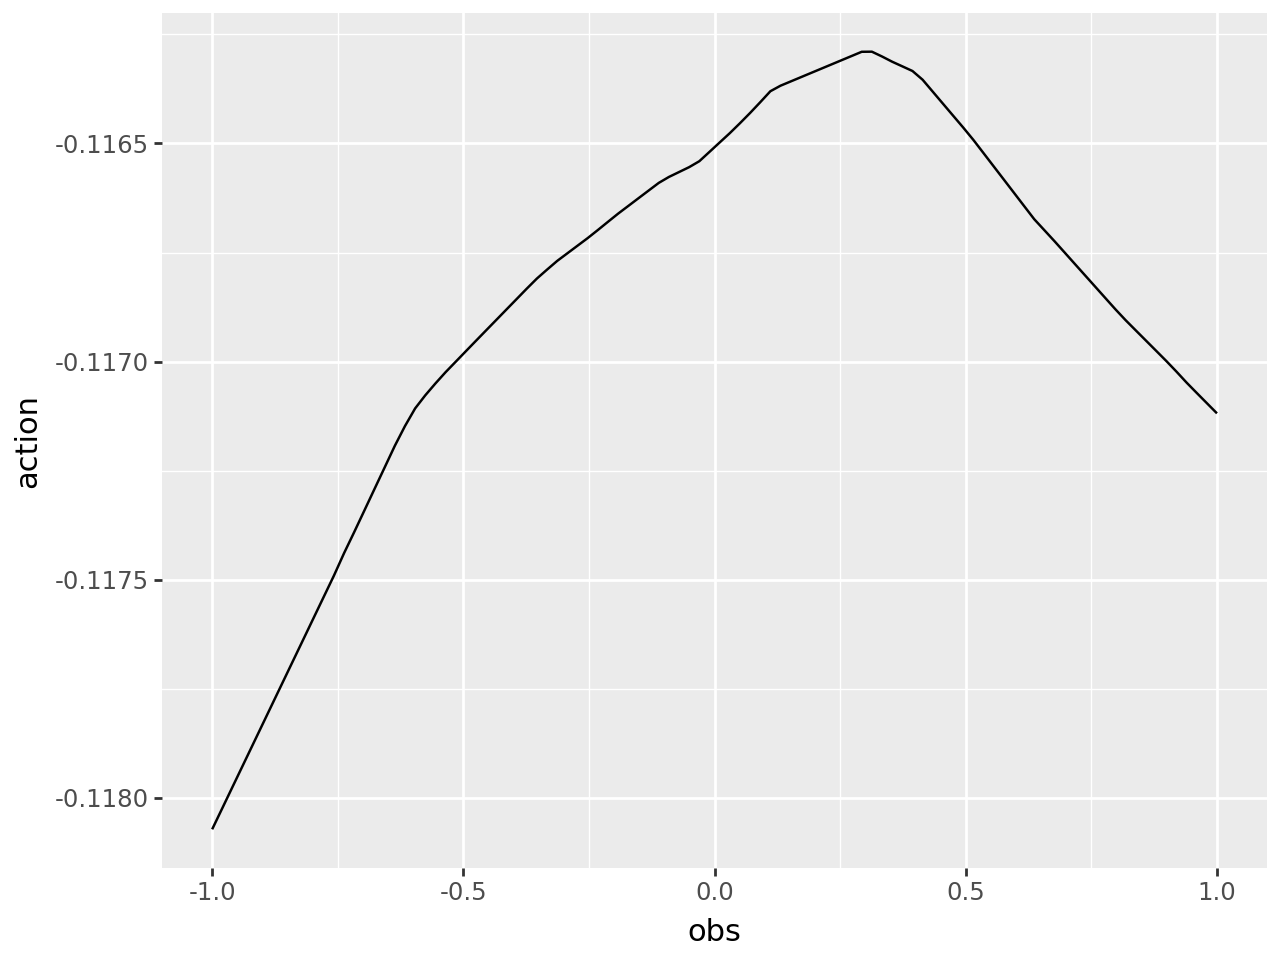

In [11]:
from utils import policy_fn
from utils import simulate_rl
import numpy as np
model = ARS("MlpPolicy", env, device="cpu")
agent = model.load("ars_fish")
#policy_fn(agent, env, N = 100)

-533.8731321885465


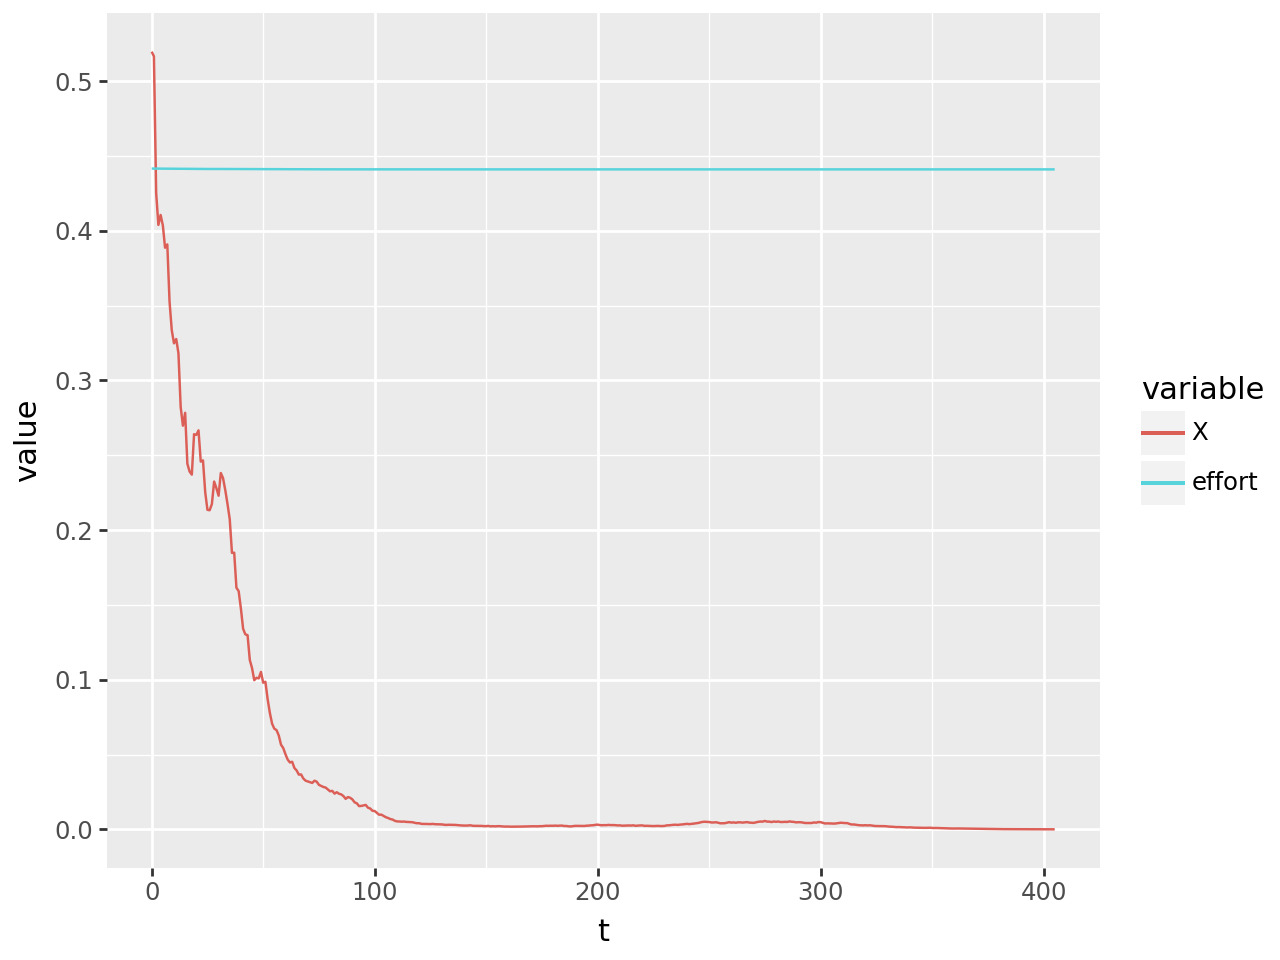

In [13]:

df, mu = simulate_rl(agent, env)
print(mu)
plot_sim(df)

In [14]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True, device = "cpu")
model.learn(total_timesteps=800_000, tb_log_name="ppo-fish", progress_bar=True)
model.save("ppo_fish")

Output()

33.890475633692255


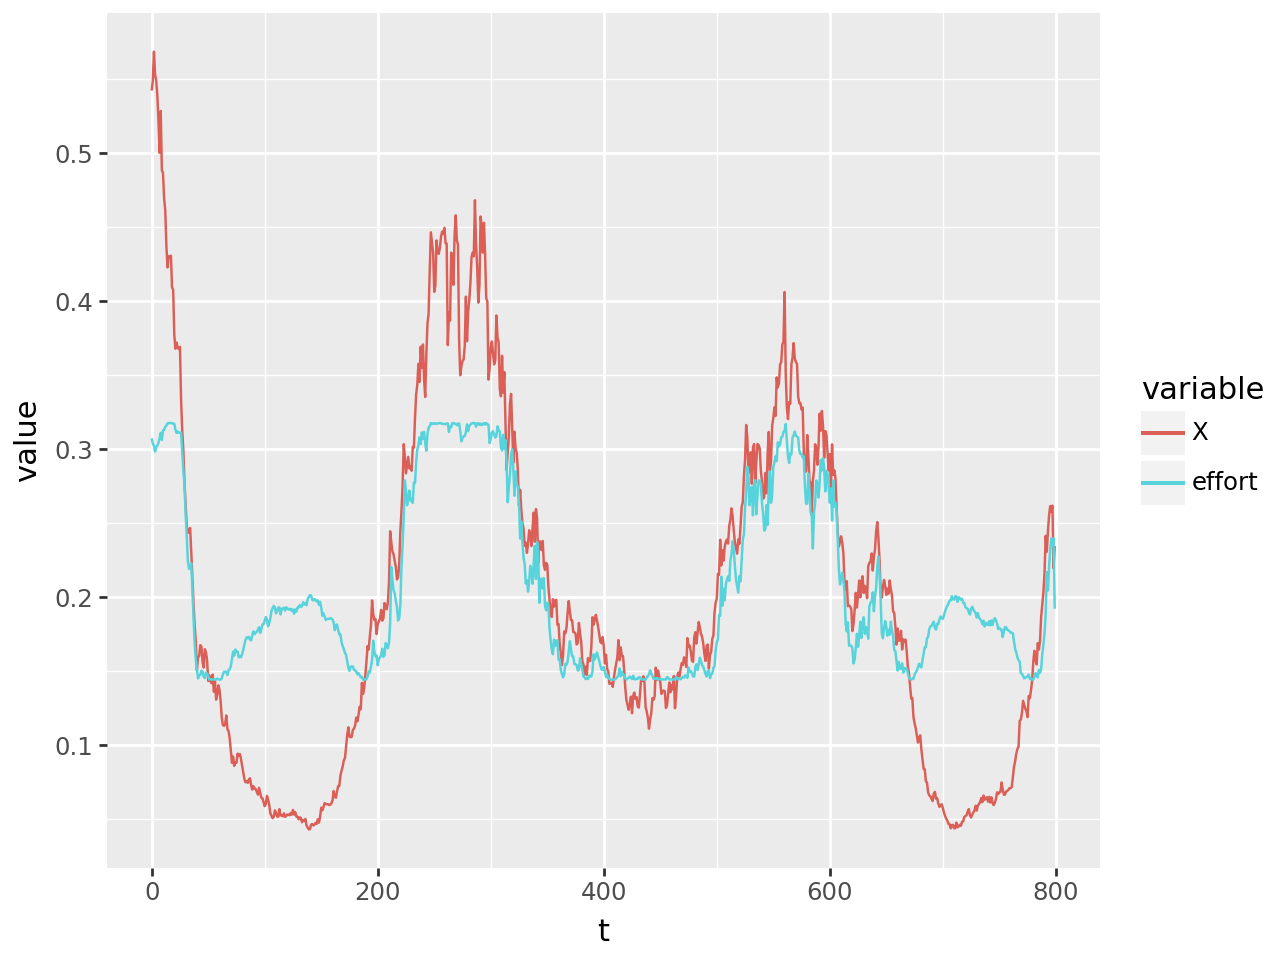

In [16]:
model = PPO("MlpPolicy", env, device="cpu")
agent = model.load("ppo_fish")

df, mu = simulate_rl(agent, env)
print(mu)
plot_sim(df)

In [ ]:
#policy_fn(agent, env, N = 100)